In [5]:
import os
import csv
import numpy as np
import pandas as pd
import string
os.environ["KERAS_BACKEND"] = "theano"
import re
import json


from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
import warnings; warnings.simplefilter('ignore')
from sklearn.linear_model import Perceptron


In [6]:
emoticons = r"""
        (?:
            [:=;] # 
            [oO\-]? # 
            [D\)\]\(\]/\\OpP] # 
        )"""
regex = [emoticons,
        r'<[^>]+>',  # HTML
        r'(?:@[\w_]+)',  # @ mentions
        r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',  # URL
        r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",  # hash tags
        r'(?:[\w_]+)',  # other words
        r'(?:\S)'  # anything else
        ]
emoticonRegex = re.compile(r'^' + emoticons + '$', re.VERBOSE | re.IGNORECASE)
tokens_re = re.compile(r'(' + '|'.join(regex) + ')', re.VERBOSE | re.IGNORECASE)
stopWords = set(stopwords.words('english') + list(string.punctuation) + list("__"))
stopWords.add('__')
stopWords.add('0084b4')
stopWords.add('c0deed')
stopWords.add('ffffff')
stopWords.add('love')
stopWords.add('like')
stopWords.add('one')
stopWords.add('get')
stopWords.add('life')
stopWords.add('day')
stopWords.add('people')
stopWords.add('go')
stopWords.add('time')
stopWords.add('know')
stopWords.add('new')
stopWords.add('im')
stopWords.add('want')
stopWords.add('good')
stopWords.add('make')
stopWords.add('eeeeee')
stopWords.add('got')
stopWords.add('amp')
stopWords.add('need')
stopWords.add('best')

#  Test pre-processing and data exploration

In [7]:
#read the tweets file
df = pd.read_csv('Information (2).csv',encoding='latin-1')

#Get only the rows with the genders
data = df.loc[df['gender'].isin(['female', 'male'])]

#if one of the coloums 'text' or 'description' is missing, concatinate it as a dot
data.loc[df['text'].isnull(),'text'] = " "
data.loc[df['description'].isnull(),'description'] = " "
data = data[ data['gender:confidence'] > 0.5 ]

#list of all final processind data witch includes text, description, link_color and sidebar_color columns in a one string.
tweets = data["text"].map(str) + " "+ data["description"]+" "+ data["link_color"]+ " "+data["sidebar_color"]

#processed tweets with gender classification each
tweetsWithGender = pd.DataFrame({'tweets': tweets, 'gender': data["gender"]}, columns=['tweets', 'gender'])

In [8]:
# tokenization function that gets one tweet each time
def tokenization(tweet):
    tweet = re.sub(r'[^\x00-\x7f]*', r'', tweet)
    tokens = tokens_re.findall(tweet)
    tokens = [token if emoticonRegex.search(token) else token.lower() for token in tokens]
    ##empty array to be filled with clean tweets
    tweetTokens = [] 
    for token in tokens:
        if token not in stopWords and not token.isdigit() and len(token) > 1:
            tweetTokens.append(token)
    return tweetTokens

In [9]:
# tokenized tweets array
tweetsNew = []
for i in tweets:
    tweetsNew.append(tokenization(i))

# tokenized tweets with gender 
tweetsNewWithGender = []
for index, row in tweetsWithGender.iterrows():
    tweetsNewWithGender.append([tokenization(row['tweets']),row['gender']])
    
# tweets texts 
TextTweetsNew =[]
for tokenized_text in tweetsNew:
    text = ""
    for token in tokenized_text:
        text += token + " "
    TextTweetsNew.append(text)

# tweets texts with gender 
TextTweetsNewWithGender = []
for tweetAndGender in tweetsNewWithGender:
    text = ""
    gender =tweetAndGender[1] 
    for token in tweetAndGender[0]:
        text += token + " "        
    TextTweetsNewWithGender.append([text,gender])

processedTweets = pd.DataFrame(TextTweetsNewWithGender, columns=['text', 'gender'])

## Data exploration

### We first find the frequency of tweets of male and female each and then we find 10 most common words for each gender

### Class distribution:

In [25]:
#Q1) What are the most common emotions/words used by Males and Females?

female    6540
male      5954
Name: gender, dtype: int64


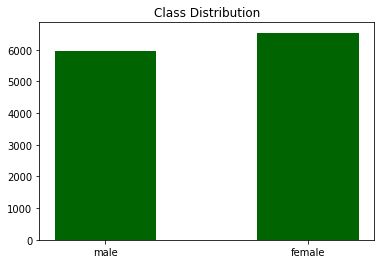

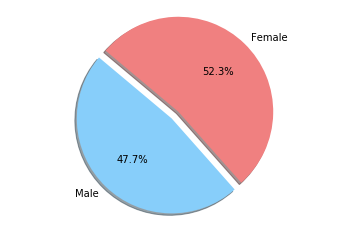

In [10]:
#Exploration
counter = Counter(data["gender"])

print(data["gender"].value_counts())

#Class Distribution:
names = counter.keys()
tweetNum = counter.values()

# Plot histogram
rowsNum = np.arange(len(names))
plt.bar(rowsNum, tweetNum, 0.5, color='darkgreen')
plt.title('Class Distribution')
plt.xticks(rowsNum, names)

#class distribution plot
plt.show()

# Data to plot
labels = 'Male', 'Female'
sizes = [list(tweetNum)[0],list(tweetNum)[1] ]
colors = [ 'lightskyblue', 'lightcoral']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [11]:
def TopWords(tweetsNew):
    counter = Counter()
    topwords = []
    for tweet in tweetsNew:
        for token in tokenization(tweet):
            topwords.append(token)
    counter.update(topwords)
    return counter.most_common(10)

## Frequency of terms for the two genders

In [12]:
print ("Top 10 words befor tokenization: \n")
print ("Top 10 words of Male:")
maleTweets = data.loc[data['gender']== 'male']['text']
print (TopWords(maleTweets))
print('\n')
print ("Top 10 words of Female:")
femaleTweets = data.loc[data['gender']=='female']['text']
print (TopWords(femaleTweets))

Top 10 words befor tokenization: 

Top 10 words of Male:
[('see', 164), ('back', 156), ('think', 156), ('would', 141), ('still', 137), ('last', 131), ('really', 116), ('way', 113), ('great', 112), ('lol', 111)]


Top 10 words of Female:
[('last', 175), ('back', 169), ('still', 160), ('___', 158), ('see', 157), ('today', 138), ('makes', 133), ('really', 132), ('think', 131), ('even', 130)]


In [13]:
print ("Top 10 words after tokenization: \n")

# male top words after tokenizing
print ("Top 10 words of Male 2:")
maleTweets2 = processedTweets.loc[df['gender']== 'male']['text']
print (TopWords(maleTweets2))
print('\n')

# female top words after tokenizing
print ("Top 10 words of Female 2:")
femaleTweets2 = processedTweets.loc[processedTweets['gender']=='female']['text']
print (TopWords(femaleTweets2))

Top 10 words after tokenization: 

Top 10 words of Male 2:
[('world', 139), ('music', 126), ('3b94d9', 125), ('back', 121), ('fan', 118), ('work', 117), ('still', 116), ('f5abb5', 114), ('see', 111), ('follow', 110)]


Top 10 words of Female 2:
[('f5abb5', 278), ('girl', 278), ('9266cc', 275), ('world', 234), ('still', 210), ('back', 205), ('see', 197), ('always', 196), ('follow', 196), ('last', 187)]


In [17]:
import numpy as np 
import pandas as pd
import re
import nltk as nlp
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [18]:
data=pd.read_csv("Information (2).csv", encoding='latin-1')
data.describe()

,_unit_id,_trusted_judgments,gender:confidence,profile_yn:confidence,fav_number,retweet_count,tweet_count,tweet_id
count,2.005000e+04,20050.000000,20024.000000,20050.000000,20050.000000,20050.000000,2.005000e+04,2.005000e+04
mean,8.157294e+08,3.615711,0.882756,0.993221,4382.201646,0.079401,3.892469e+04,6.587350e+17
std,6.000801e+03,12.331890,0.191403,0.047168,12518.575919,2.649751,1.168371e+05,5.000124e+12
min,8.157192e+08,3.000000,0.000000,0.627200,0.000000,0.000000,1.000000e+00,6.587300e+17
25%,8.157243e+08,3.000000,0.677800,1.000000,11.000000,0.000000,2.398000e+03,6.587300e+17
50%,8.157294e+08,3.000000,1.000000,1.000000,456.000000,0.000000,1.144150e+04,6.587300e+17
75%,8.157345e+08,3.000000,1.000000,1.000000,3315.500000,0.000000,4.002750e+04,6.587400e+17
max,8.157580e+08,274.000000,1.000000,1.000000,341621.000000,330.000000,2.680199e+06,6.587400e+17


In [26]:
#Q2) Which gender makes more typos in their tweets? (Has been done based on gender confidence.) 
#Genders with maximum values of confidence less than 1 has been considered to make more number of typos.

In [27]:
data2=data[['gender','gender:confidence']]
data2.dropna()

,gender,gender:confidence
0,male,1.0000
1,male,1.0000
2,male,0.6625
3,male,1.0000
4,female,1.0000
...,...,...
20045,female,1.0000
20046,male,1.0000
20047,male,1.0000
20048,female,0.8489


In [28]:
data2.gender.value_counts()

female     6700
male       6194
brand      5942
unknown    1117
Name: gender, dtype: int64

In [29]:
Male_conf=data2[data2['gender']=='male']
Male_conf=Male_conf[Male_conf['gender:confidence']<1]

Female_conf=data2[data2['gender']=='female']
Female_conf=Female_conf[Female_conf['gender:confidence']<1]

Brand_conf=data2[data2['gender']=='brand']
Brand_conf=Brand_conf[Brand_conf['gender:confidence']<1]

Unknown_conf=data2[data2['gender']=='unknown']
Unknown_conf=Unknown_conf[Unknown_conf['gender:confidence']<1]

print("Number of males with confidence less than 1 =" + str(Male_conf.shape[0]) + "\n"
      "Number of females with confidence less than 1 =" + str(Female_conf.shape[0]) + "\n"
      "Number of brands with confidence less than 1 =" + str(Brand_conf.shape[0]) + "\n"
      "Number of unknowns with confidence less than 1 =" + str(Unknown_conf.shape[0]) + "\n")

Number of males with confidence less than 1 =1541
Number of females with confidence less than 1 =1333
Number of brands with confidence less than 1 =2158
Number of unknowns with confidence less than 1 =995



In [19]:
data.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'profileimage',
       'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

In [21]:
data1=data[['gender','text']]
data1.dropna()

,gender,text
0,male,Robbie E Responds To Critics After Win Against...
1,male,ÛÏIt felt like they were my friends and I was...
2,male,i absolutely adore when louis starts the songs...
3,male,Hi @JordanSpieth - Looking at the url - do you...
4,female,Watching Neighbours on Sky+ catching up with t...
...,...,...
20045,female,"@lookupondeath ...Fine, and I'll drink tea too..."
20046,male,Greg Hardy you a good player and all but don't...
20047,male,You can miss people and still never want to se...
20048,female,@bitemyapp i had noticed your tendency to pee ...


# Training an ML model

In [14]:
Tfidf_vectorizer = TfidfVectorizer()


#creating train and test sets. The test size will be 0.2% of the data.
X_train, X_test, y_train, y_test = train_test_split(TextTweetsNew,data["gender"], test_size=0.20, shuffle = True)

#### We train the models first. For each one of them, we try two feature extraction methods: TF-IDF and Bag of Words. Also, we will tune the parameters of the machine learning models and eventually choose the best classifier and feature extraction method. The best combination will be the one with the best accuracy. 

In [15]:
def calcModels():
    bestAccuracy = 0.0
    for clf, clf_name in ((SGDClassifier(),"SVM"), (MultinomialNB(),"Naive Bayes")):
        print('=' * 80)
        print(clf_name)
        for fe ,fe_name in ((TfidfVectorizer(), "TF-IDF"), (CountVectorizer(),"Bag of Words")):
            print('-' * 80)
            print(fe_name)
            parameters =  {'vect__max_df': (0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0),'clf__alpha': (0.00001,0.0001,0.001,0.01,0.1,1.0)}
            nb_clf =Pipeline([('vect',fe ), ('clf',clf )])
            gs_clf = GridSearchCV(nb_clf, parameters, n_jobs=1)
            gs_clf = gs_clf.fit(X_train, y_train.tolist())
            prediction = gs_clf.predict(X_test)
            accuracy = metrics.accuracy_score(y_test.tolist(), prediction)
            print('accuracy:', accuracy)
            print('Best score: ',gs_clf.best_score_)
            print('Best params: ',gs_clf.best_params_)

            if accuracy > bestAccuracy:
                    bestAccuracy = accuracy
                    bestFeature = fe_name
                    bestCLF = clf_name
                    bestParams= gs_clf.best_params_
    
   
    print("")
    print(":best results")
    print("feature extraction method-",bestFeature)
    print("classifier-",bestCLF)
    print("accurecy-",bestAccuracy)

In [16]:
calcModels()

SVM
--------------------------------------------------------------------------------
TF-IDF
accuracy: 0.6918767507002801
Best score:  0.671735867933967
Best params:  {'clf__alpha': 0.0001, 'vect__max_df': 1.0}
--------------------------------------------------------------------------------
Bag of Words
accuracy: 0.6794717887154862
Best score:  0.6670335167583792
Best params:  {'clf__alpha': 0.001, 'vect__max_df': 0.4}
Naive Bayes
--------------------------------------------------------------------------------
TF-IDF
accuracy: 0.6798719487795118
Best score:  0.6768384192096049
Best params:  {'clf__alpha': 1.0, 'vect__max_df': 0.3}
--------------------------------------------------------------------------------
Bag of Words
accuracy: 0.6922769107643058
Best score:  0.6861430715357678
Best params:  {'clf__alpha': 1.0, 'vect__max_df': 0.4}

:best results
feature extraction method- Bag of Words
classifier- Naive Bayes
accurecy- 0.6922769107643058


In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 12,10

In [4]:
df = pd.read_csv("Information (2).csv",encoding='latin-1')
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


In [6]:
#summarize the data
df.describe()

,_unit_id,_trusted_judgments,gender:confidence,profile_yn:confidence,fav_number,retweet_count,tweet_count,tweet_id
count,2.005000e+04,20050.000000,20024.000000,20050.000000,20050.000000,20050.000000,2.005000e+04,2.005000e+04
mean,8.157294e+08,3.615711,0.882756,0.993221,4382.201646,0.079401,3.892469e+04,6.587350e+17
std,6.000801e+03,12.331890,0.191403,0.047168,12518.575919,2.649751,1.168371e+05,5.000124e+12
min,8.157192e+08,3.000000,0.000000,0.627200,0.000000,0.000000,1.000000e+00,6.587300e+17
25%,8.157243e+08,3.000000,0.677800,1.000000,11.000000,0.000000,2.398000e+03,6.587300e+17
50%,8.157294e+08,3.000000,1.000000,1.000000,456.000000,0.000000,1.144150e+04,6.587300e+17
75%,8.157345e+08,3.000000,1.000000,1.000000,3315.500000,0.000000,4.002750e+04,6.587400e+17
max,8.157580e+08,274.000000,1.000000,1.000000,341621.000000,330.000000,2.680199e+06,6.587400e+17


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _golden                20050 non-null  bool   
 2   _unit_state            20050 non-null  object 
 3   _trusted_judgments     20050 non-null  int64  
 4   _last_judgment_at      20000 non-null  object 
 5   gender                 19953 non-null  object 
 6   gender:confidence      20024 non-null  float64
 7   profile_yn             20050 non-null  object 
 8   profile_yn:confidence  20050 non-null  float64
 9   created                20050 non-null  object 
 10  description            16306 non-null  object 
 11  fav_number             20050 non-null  int64  
 12  gender_gold            50 non-null     object 
 13  link_color             20050 non-null  object 
 14  name                   20050 non-null  object 
 15  pr

In [8]:
df = df.drop(['_unit_id', '_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'profile_yn', 'profile_yn:confidence', 'created', 'description', 'gender_gold', 'link_color', 'profile_yn_gold', 'profileimage', 'sidebar_color', 'text', 'tweet_coord', 'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone', 'gender:confidence', 'name'],axis=1)

In [9]:
df

,gender,fav_number,retweet_count,tweet_count
0,male,0,0,110964
1,male,68,0,7471
2,male,7696,1,5617
3,male,202,0,1693
4,female,37318,0,31462
...,...,...,...,...
20045,female,302,0,783
20046,male,2513,0,13523
20047,male,50,0,26419
20048,female,70804,0,56073


In [10]:
df.gender=[1 if each =="female" else 0 for each in df.gender]
df

,gender,fav_number,retweet_count,tweet_count
0,0,0,0,110964
1,0,68,0,7471
2,0,7696,1,5617
3,0,202,0,1693
4,1,37318,0,31462
...,...,...,...,...
20045,1,302,0,783
20046,0,2513,0,13523
20047,0,50,0,26419
20048,1,70804,0,56073


In [11]:
Y=df[["gender"]].values
X=df[["fav_number","retweet_count","tweet_count"]].values

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [13]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
# training Linear Regression model on training data
rfc.fit(X_train, Y_train)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
y_pred = rfc.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print (classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.74      3339
           1       0.45      0.38      0.41      1674

    accuracy                           0.64      5013
   macro avg       0.58      0.57      0.57      5013
weighted avg       0.62      0.64      0.63      5013



# Conclusion:

Thus, we took the tweets dataset and then cleaned it to remove unwanted columns and certain rows containing invalid values or outliers. Then we compared the tweet count of the two genders using EDA and Visualized the frequency of the two genders. We also removed stopwords. We applied TF-IDF for feature classification to make the algorithms understand the text content better. We were asked to frame two questions and answer them, which were :
1) What is the most common emotion/words for each gender? 
2) Which gender makes more typos in tweets? 
Both of these questions were answered with the help of dataframe analysis. Then, we come to the classification algorithms and calculating their respective accuracies and comparing them. We observed that Naive Bayes algo gives the best accuracy of around 69% if the feature extraction method used is Bag of Words.